In [ ]:
import sys
import warnings
warnings.filterwarnings('ignore')
import joblib
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os

PRJ_DIR = os.path.abspath('')

np.random.seed(42)

#Data Loading

In [ ]:
data = pd.read_csv(os.path.join(PRJ_DIR, 'data', 'train', 'data.csv'))
data.sample(10)

,minute,half,ht_elo,at_elo,ht_goal,at_goal,pass,final_3rd_pass,key_pass,corner,big_chance,shot,red,result
91808,39,1,1656.107422,1691.225098,0,0,-18,21,3,1,1,1,0,W
37954,84,2,1614.175537,1691.470581,1,2,196,56,5,7,1,7,0,L
131408,58,2,1682.737061,1744.719482,2,2,-108,-54,0,-3,0,-2,0,L
85389,35,1,1771.272583,1928.467773,1,1,-202,-62,-4,-3,-1,-5,0,L
118631,9,1,1703.093994,1718.697998,0,0,0,7,2,1,1,4,0,D
4417,79,2,1716.718628,1679.988159,2,1,27,18,0,3,0,3,0,W
139763,28,1,1859.192139,2041.219971,0,1,-21,-17,0,3,1,1,0,L
67681,48,2,1893.121094,1612.396240,1,0,224,118,8,4,0,6,0,W
49601,26,1,1848.316284,1671.378296,1,0,91,21,0,-1,1,0,0,W
73832,93,2,1573.287109,1627.961792,1,1,-384,-87,-1,2,0,-3,0,D


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150013 entries, 0 to 150012
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   minute          150013 non-null  int64  
 1   half            150013 non-null  int64  
 2   ht_elo          150013 non-null  float64
 3   at_elo          150013 non-null  float64
 4   ht_goal         150013 non-null  int64  
 5   at_goal         150013 non-null  int64  
 6   pass            150013 non-null  int64  
 7   final_3rd_pass  150013 non-null  int64  
 8   key_pass        150013 non-null  int64  
 9   corner          150013 non-null  int64  
 10  big_chance      150013 non-null  int64  
 11  shot            150013 non-null  int64  
 12  red             150013 non-null  int64  
 13  result          150013 non-null  object 
dtypes: float64(2), int64(11), object(1)
memory usage: 16.0+ MB


In [ ]:
data.isnull().sum()

minute            0
half              0
ht_elo            0
at_elo            0
ht_goal           0
at_goal           0
pass              0
final_3rd_pass    0
key_pass          0
corner            0
big_chance        0
shot              0
red               0
result            0
dtype: int64

#Data Preprocessing

In [ ]:
x = data.drop(['result'], axis = 1)
y = data['result']
x = x.values
y = y.values

In [ ]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
scaler = StandardScaler()
x = scaler.fit_transform(x)

result_map = {'W': 0, 'D': 1, 'L': 2}
y = np.array([result_map[val] for val in y])

#Model Selection

In [ ]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer

Ranked Probability Score

In [ ]:
def rps_score(outcomes, predictions):
  # print(predictions)
  # print(outcomes)
  loss = 0
  for i, p in enumerate(predictions):
    outcome = [1 if x == outcomes[i] else 0 for x in range(3)]
    tmp = probs = outs = 0
    for j, val in enumerate(predictions[i]):
      probs += val
      outs += outcome[j]
      tmp += (probs - outs) ** 2
    loss += tmp / 2
  loss /= len(predictions)
  return 1 - loss

In [ ]:
rps_scorer = make_scorer(rps_score, greater_is_better=True, needs_proba=True)

LogisticRegression Ranked Probability Score: 0.8520729060337505
KNeighborsClassifier Ranked Probability Score: 0.9861214040468014
DecisionTreeClassifier Ranked Probability Score: 0.9926830894363144
GaussianNB Ranked Probability Score: 0.8144813704870076
RandomForestClassifier Ranked Probability Score: 0.9910563860462016
AdaBoostClassifier Ranked Probability Score: 0.7841295539898065
GradientBoostingClassifier Ranked Probability Score: 0.8798619593429535
XGBClassifier Ranked Probability Score: 0.9764369952623071
LinearDiscriminantAnalysis Ranked Probability Score: 0.8472901164639506
QuadraticDiscriminantAnalysis Ranked Probability Score: 0.8503318762333798


<Axes: title={'center': 'Ranked Probability Score'}, xlabel='Score', ylabel='Classifier'>

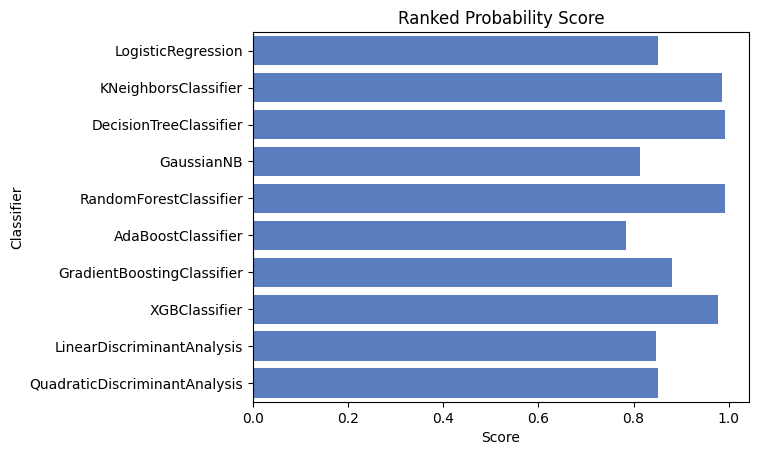

In [ ]:
classifiers = [
    LogisticRegression(multi_class='multinomial', solver='sag', max_iter=1000),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
	  AdaBoostClassifier(),
    GradientBoostingClassifier(),
    XGBClassifier(objective='multi:softprob', num_class=3, random_state=42),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()
 ]

acc_dict = {}

sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(x, y):
  xtrain, xtest = x[train_index], x[test_index]
  ytrain, ytest = y[train_index], y[test_index]
  for clf in classifiers:
    name = clf.__class__.__name__

    clf.fit(xtrain, ytrain)
    predictions = clf.predict_proba(xtest)
    acc = rps_score(ytest, predictions)
    if name in acc_dict:
      acc_dict[name] += acc
    else:
      acc_dict[name] = acc

log = []

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    print(clf, 'Ranked Probability Score:', acc_dict[clf])
    log.append({'Classifier': clf, 'Score': acc_dict[clf]})

log = pd.DataFrame(log)

plt.xlabel('Score')
plt.title('Ranked Probability Score')

sns.set_color_codes("muted")
sns.barplot(x='Score', y='Classifier', data=log, color="b")

#Fine-tuning the Hyperparameters

In [ ]:
def save_model(model, name, folder_path):
    joblib.dump(model, os.path.join(folder_path, name + ".pkl"))
    print("Saved model", name)
def load_model(path):
    return joblib.load(path)

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
from skopt import BayesSearchCV

In [ ]:
result = {}

In [ ]:
# create dataset for Calibrated Classifier after Hyper-tuning
xtrain, xcalib, ytrain, ycalib = train_test_split(x, y, test_size=0.2, random_state=42)

##KNN

In [ ]:
knn_tuning = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (3, 20),
        'weights' : ['uniform','distance'],
        'metric' : ['minkowski','euclidean','manhattan']
    },
    n_iter=50,
    scoring=rps_scorer,
    cv=5,
    random_state=42
)
knn_tuning.fit(xtrain, ytrain)
print('Best score:', knn_tuning.best_score_)
print('Best params:', knn_tuning.best_params_)

Best score: 0.786054404930962
Best params: OrderedDict([('metric', 'manhattan'), ('n_neighbors', 20), ('weights', 'uniform')])


In [ ]:
result[knn_tuning.best_estimator_.__class__.__name__] = knn_tuning.best_score_

In [ ]:
save_model(knn_tuning.best_estimator_, 'K Nearest Neighbors', os.path.join(PRJ_DIR, 'model'))

Saved model K Nearest Neighbors


In [ ]:
calibrated_knn = CalibratedClassifierCV(knn_tuning.best_estimator_, cv='prefit', method='isotonic')
calibrated_knn.fit(xcalib, ycalib)

CalibratedClassifierCV(cv='prefit',
                       estimator=KNeighborsClassifier(metric='manhattan',
                                                      n_neighbors=20),
                       method='isotonic')

In [ ]:
save_model(calibrated_knn, 'Calibrated K Nearest Neighbors', os.path.join(PRJ_DIR, 'model'))

Saved model Calibrated K Nearest Neighbors


##Decision Tree

In [ ]:
dt_tuning = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    {
        'max_depth': (3, 40),
        'min_samples_split': (2, 40),
        'min_samples_leaf': (1, 20),
        'max_features': [None, "sqrt", "log2"],
        'max_leaf_nodes': (10, 200),
        'min_impurity_decrease': (1e-5, 0.5, "uniform"),
        'class_weight': [None, "balanced"]
    },
    n_iter=100,
    scoring=rps_scorer,
    cv=5,
    random_state=42
)
dt_tuning.fit(xtrain, ytrain)
print('Best score:', dt_tuning.best_score_)
print('Best params:', dt_tuning.best_params_)

Best score: 0.8483463828082435
Best params: OrderedDict([('class_weight', None), ('max_depth', 24), ('max_features', None), ('max_leaf_nodes', 14), ('min_impurity_decrease', 1.0000000000000434e-05), ('min_samples_leaf', 9), ('min_samples_split', 8)])


In [ ]:
result[dt_tuning.best_estimator_.__class__.__name__] = dt_tuning.best_score_

In [ ]:
save_model(dt_tuning.best_estimator_, 'Decision Tree', os.path.join(PRJ_DIR, 'model'))

Saved model Decision Tree


In [ ]:
calibrated_dt = CalibratedClassifierCV(dt_tuning.best_estimator_, cv='prefit', method='isotonic')
calibrated_dt.fit(xcalib, ycalib)

CalibratedClassifierCV(cv='prefit',
                       estimator=DecisionTreeClassifier(max_depth=24,
                                                        max_leaf_nodes=14,
                                                        min_impurity_decrease=1.0000000000000434e-05,
                                                        min_samples_leaf=9,
                                                        min_samples_split=8,
                                                        random_state=42),
                       method='isotonic')

In [ ]:
save_model(calibrated_dt, 'Calibrated Decision Tree', os.path.join(PRJ_DIR, 'model'))

Saved model Calibrated Decision Tree


##Random Forest

In [ ]:
rf_tuning = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    {
        'n_estimators': (100, 1000, 50),
        'max_depth': (10, 100),
        'min_samples_split': (2, 20),
        'min_samples_leaf': (1, 5),
        'max_features': [None, "sqrt", "log2"],
        'bootstrap': [True, False]
    },
    n_iter=50,
    scoring=rps_scorer,
    cv=5,
    random_state=42
)
rf_tuning.fit(xtrain, ytrain)
print('Best score:', rf_tuning.best_score_)
print('Best params:', rf_tuning.best_params_)

Best score: 0.8479212850842527
Best params: OrderedDict([('bootstrap', True), ('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 1000)])


In [ ]:
result[rf_tuning.best_estimator_.__class__.__name__] = rf_tuning.best_score_

In [ ]:
save_model(rf_tuning.best_estimator_, 'Random Forest', os.path.join(PRJ_DIR, 'model'))

Saved model Random Forest


In [ ]:
calibrated_rf = CalibratedClassifierCV(rf_tuning.best_estimator_, cv='prefit', method='isotonic')
calibrated_rf.fit(xcalib, ycalib)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(max_depth=10,
                                                        min_samples_leaf=5,
                                                        n_estimators=1000,
                                                        random_state=42),
                       method='isotonic')

In [ ]:
save_model(calibrated_rf, 'Calibrated Random Forest', os.path.join(PRJ_DIR, 'model'))

Saved model Calibrated Random Forest


Feature Importance

In [ ]:
feat_importances = pd.DataFrame({'Attribute': data.columns[:-1], 'Feature Importance': rf_tuning.best_estimator_.feature_importances_})
feat_importances = feat_importances.sort_values(by='Feature Importance', ascending=False)
feat_importances = feat_importances.reset_index(drop=True)
feat_importances

,Attribute,Feature Importance
0,ht_goal,0.244434
1,at_goal,0.228560
2,ht_elo,0.140523
3,at_elo,0.122644
4,big_chance,0.046804
5,shot,0.042438
6,pass,0.041236
7,key_pass,0.035963
8,final_3rd_pass,0.031104
9,minute,0.028107


##XGBoost

In [ ]:
xgb_tuning = BayesSearchCV(
    XGBClassifier(objective='multi:softprob', num_class=3, random_state=42),
    {
        'max_depth': (3, 10),
        'n_estimators': (100, 1000, 50),
        'learning_rate': (0.01, 0.3),
        'colsample_bytree': (0.5, 1),
        'subsample': (0.6, 1)
    },
    n_iter=100,
    scoring=rps_scorer,
    cv=5,
    random_state=42
)
xgb_tuning.fit(xtrain, ytrain)
print('Best score:', xgb_tuning.best_score_)
print('Best params:', xgb_tuning.best_params_)

Best score: 0.8514379847522632
Best params: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.06737032480400212), ('max_depth', 7), ('n_estimators', 50), ('subsample', 0.6)])


In [ ]:
result[xgb_tuning.best_estimator_.__class__.__name__] = xgb_tuning.best_score_

In [ ]:
save_model(xgb_tuning.best_estimator_, 'XGBoost', os.path.join(PRJ_DIR, 'model'))

Saved model XGBoost


In [ ]:
xgb_model = load_model('/content/XGBoost.pkl')

In [ ]:
calibrated_xgb = CalibratedClassifierCV(xgb_tuning.best_estimator_, cv='prefit', method='isotonic')
calibrated_xgb.fit(xcalib, ycalib)

CalibratedClassifierCV(cv='prefit',
                       estimator=XGBClassifier(base_score=None, booster=None,
                                               callbacks=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=1.0,
                                               device=None,
                                               early_stopping_rounds=None,
                                               enable_categorical=False,
                                               eval_metric=None,
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=0.06737032480400212,
                                               max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None, max_depth=7,
                                               max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=50, n_jobs=None,
                                               num_class=3,
                                               num_parallel_tree=None, ...),
                       method='isotonic')

In [ ]:
save_model(calibrated_xgb, 'Calibrated XGBoost', os.path.join(PRJ_DIR, 'model'))

Saved model Calibrated XGBoost


##Model scores after fine-tuning

In [ ]:
df = pd.DataFrame(list(result.items()), columns=['Classifier', 'Score'])
df = df.sort_values(by='Score', ascending=False)
df = df.reset_index(drop=True)
df

,Classifier,Score
0,XGBClassifier,0.851438
1,DecisionTreeClassifier,0.848346
2,RandomForestClassifier,0.847921
3,KNeighborsClassifier,0.786054
